# Uniform Heating in EBTEL

Having some issues with peak temperature in emission measure distribution. What happens when we just heat the plasma uniformly according to the scaling?

In [239]:
import sys
import os
import logging
from imp import reload
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.append('/home/wtb2/Documents/EBTEL_C/bin/')
sys.path.append('/home/wtb2/Documents/EBTEL_analysis/src/')
import ebtel_wrapper as ew
import em_binner as emb
import ebtel_plot as ebp
import ebtel_run as ebr
reload(ebp)

/opt/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'ebtel_plot' from '/home/wtb2/Documents/EBTEL_analysis/src/ebtel_plot.py'>

Configure a basic EBTEL run in which there is only 1 heating event that lasts the entire duration of the simulation.

In [240]:
runner_sf = ebr.Runner('/home/wtb2/Documents/EBTEL_C/bin/','')
runner_tf = ebr.Runner('/home/wtb2/Documents/EBTEL-2fluid_repo/bin/','')

In [241]:
#input dictionary
config_dict = {'usage_option':'no_dem','rad_option':'rk','dem_option':'new','heat_flux_option':'limited',
              'solver':'rka4','ic_mode':'st_eq','print_plasma_params':'True','heat_species':'electron'}
config_dict['total_time'] = 8e+4
config_dict['tau'] = 0.5
config_dict['rka_error'] = 1.0e-6
config_dict['index_dem'] = 451
config_dict['sat_limit'] = 1.0/6.0
config_dict['h_back'] = 3.5e-5
config_dict['heating_shape'] = 'square'
config_dict['t_start_switch'] = 'uniform'
config_dict['t_end_switch'] = 'uniform'
config_dict['T0'] = 1.0e+6
config_dict['n0'] = 1.0e+8
config_dict['t_start'] = 0.0
config_dict['mean_t_start'] = 1000
config_dict['std_t_start'] = 1000
config_dict['amp_switch'] = 'uniform'
config_dict['amp0'] = 0.001
config_dict['amp1'] = 0.01
config_dict['alpha'] = 1.5
config_dict['loop_length'] = 40.0
config_dict['num_events'] = 1
config_dict['t_pulse_half'] = config_dict['total_time']/2.
config_dict['sample_rate'] = 10
config_dict['r3_grav_correction'] = 'True'
config_dict['r3_loss_correction'] = 'True'
config_dict['r3_cond_0'] = 6.0
config_dict['r3_rad_0'] = 0.6
config_dict['output_file'] = os.path.join(os.environ['RESEARCH_DIR'],'research_notebook/EBTEL/ebtel_data/flat_heating')

In [265]:
hn_eq = 3.6e-3
hn_factor= 1.#7.8e-7/8.12e-7

Configure uniform heating rate based on hydrodynamic scaling laws for a peak heating rate of 4 MK.

In [266]:
7.8e-7*(4.e+6)**(3.5)/(config_dict['loop_length']*1.0e+8)**2

0.00624

In [267]:
config_dict['h_nano'] = hn_eq#7.8e-7*(4.e+6)**(3.5)/(config_dict['loop_length']*1.0e+8)**2

Run the two-fluid model first with electron heating.

In [268]:
ew.print_xml_config(config_dict,config_file=config_dict['output_file']+'.xml')

In [269]:
runner_tf.run_ebtel_single(config_dict['output_file']+'.xml',verbose=False)

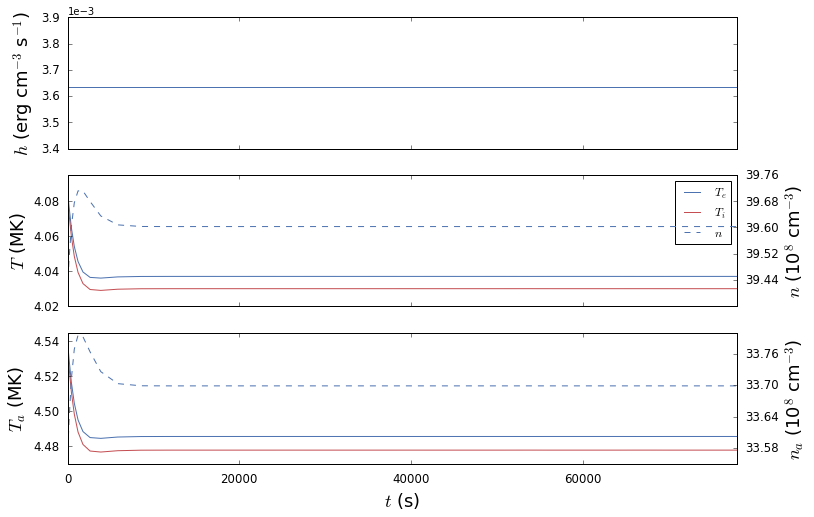

In [270]:
plotter = ebp.Plotter(lvl0_filename=config_dict['output_file'])
plotter.plot_params()

Create emission measure distribution

In [271]:
binner = emb.EM_Binner(config_dict['loop_length']*2e+8,time=plotter.time,temp=plotter.temp_e,density=plotter.dens)

In [272]:
binner.build_em_dist()

Now run the single-fluid model.

In [273]:
config_dict['h_nano'] = hn_factor*config_dict['h_nano']
ew.print_xml_config(config_dict,config_file=config_dict['output_file']+'.xml')
runner_sf.run_ebtel_single(config_dict['output_file']+'.xml',verbose=False)

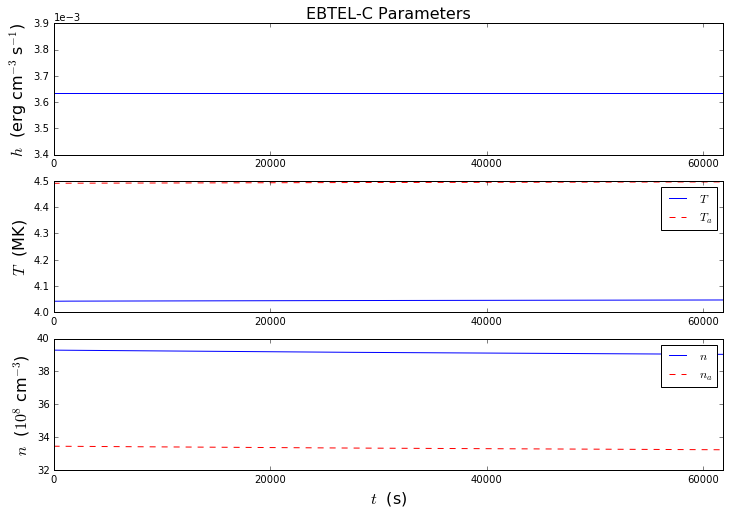

In [274]:
#plotter = ebp.Plotter(lvl0_filename=config_dict['output_file'],two_fluid=False)
#plotter.plot_params()
ew.plot_ebtel('',config_dict['output_file']+'.txt')

Make the emission measure distribution.

In [275]:
data = np.loadtxt(config_dict['output_file']+'.txt')
binner_single = emb.EM_Binner(config_dict['loop_length']*2e+8)
binner_single.set_data(data[:,0],data[:,1],data[:,2])
binner_single.build_em_dist()

Plot the two emission measure distributions

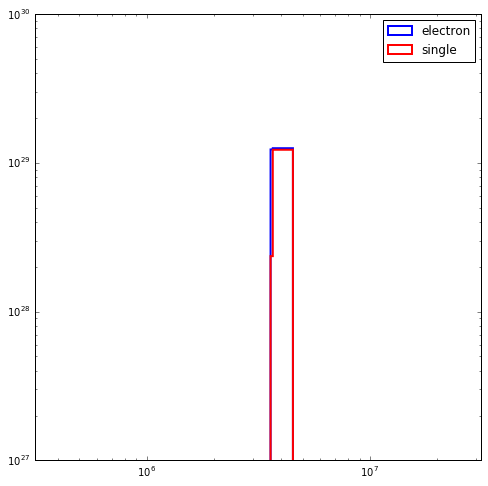

In [276]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.hist(binner.T_em_flat,bins=binner.T_em_histo_bins,weights=binner.em_flat,histtype='step',color='b',linewidth=2,
       label='electron')
ax.hist(binner_single.T_em_flat,bins=binner_single.T_em_histo_bins,weights=binner_single.em_flat,histtype='step',
        color='r',linewidth=2,label='single')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([10**5.5,10**7.5])
ax.set_ylim([10**27.,10**30.])
ax.legend()

Note that we have to enhance the two-fluid heating rate slightly.

In [277]:
7.8e-7*(4.e+6/0.6)**(3.5)/(2.*config_dict['loop_length']*1.0e+8)**2

0.009323848796425263

In [278]:
5.09e+4/((1.83e+3*0.6)**3.5)*((4.e+6)**3.5)/((40.e+8)**2.)

0.00928324001062819